In [17]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__


'1.12.1+cu116'

In [18]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [19]:
# Create some data using the linear regression formula of y = weight * X + bias
weight = 0.3
bias = 0.9

# Create range values
start = 0
end = 1
step = 0.01

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(
    dim=1)  # without unsqueeze, error will pop up
y = weight * X + bias
X[:10], y[:10]


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.9000],
         [0.9030],
         [0.9060],
         [0.9090],
         [0.9120],
         [0.9150],
         [0.9180],
         [0.9210],
         [0.9240],
         [0.9270]]))

In [20]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)


(80, 80, 20, 20)

In [21]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
    """
    Plots training data, test data and compares predictions
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing Data")

    # Are there predictions
    if predictions is not None:
        # Plot the predictions if they exist
        plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")
    plt.legend(prop={"size": 14})


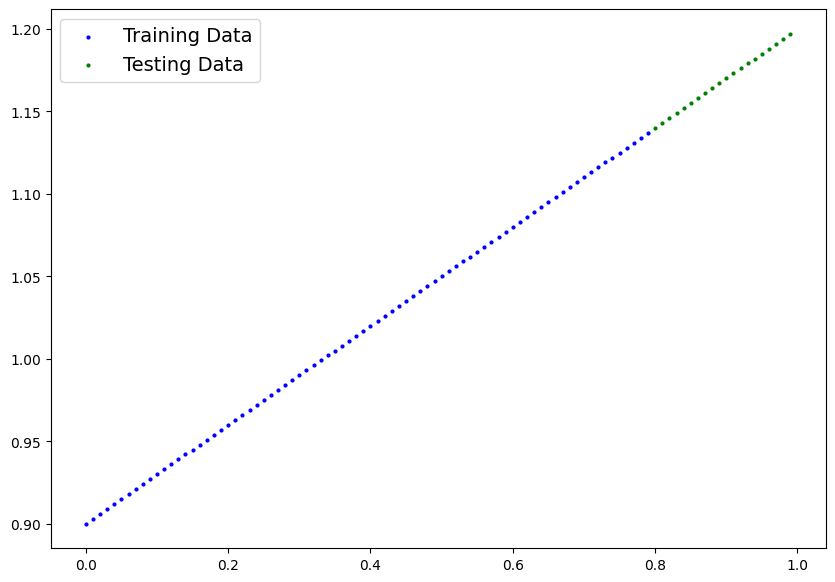

In [22]:
# Plot the data
# Note: if you dont have the plot_predictions() function loaded, this will error
plot_predictions(X_train, y_train, X_test, y_test)


In [23]:
# Create a linear regression model class
# <-- almost everything in PyTorch inherits from nn.Module
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # use nn.Linear() for creating the model parameters / also called: Linear transform, probing layer, fully connected layer
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)


In [24]:
# Set the manual seed
torch.manual_seed(42)
model_2 = LinearRegressionModel()
model_2, model_2.state_dict()


(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [25]:
# Set the model to use the target device
model_2.to(device)
next(model_2.parameters()).device


device(type='cuda', index=0)

In [26]:
# Setup loss function
loss_fn = nn.L1Loss()  # same as MAE

# Setup optimizer
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)


In [39]:
# Write a training loop
torch.manual_seed(42)

epochs = 300

# Put device on the target device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_2.train()

    # 1. Forward Pass
    y_pred = model_2(X_train)

    # 2. Calculate Loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test)

        test_loss = loss_fn(test_pred, y_test)

    # print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")


Epoch: 0 | Loss: 0.007878492586314678 | Test loss: 0.007064235396683216
Epoch: 10 | Loss: 0.007878492586314678 | Test loss: 0.007064235396683216
Epoch: 20 | Loss: 0.007878492586314678 | Test loss: 0.007064235396683216
Epoch: 30 | Loss: 0.007878492586314678 | Test loss: 0.007064235396683216
Epoch: 40 | Loss: 0.007878492586314678 | Test loss: 0.007064235396683216
Epoch: 50 | Loss: 0.007878492586314678 | Test loss: 0.007064235396683216
Epoch: 60 | Loss: 0.007878492586314678 | Test loss: 0.007064235396683216
Epoch: 70 | Loss: 0.007878492586314678 | Test loss: 0.007064235396683216
Epoch: 80 | Loss: 0.007878492586314678 | Test loss: 0.007064235396683216
Epoch: 90 | Loss: 0.007878492586314678 | Test loss: 0.007064235396683216
Epoch: 100 | Loss: 0.007878492586314678 | Test loss: 0.007064235396683216
Epoch: 110 | Loss: 0.007878492586314678 | Test loss: 0.007064235396683216
Epoch: 120 | Loss: 0.007878492586314678 | Test loss: 0.007064235396683216
Epoch: 130 | Loss: 0.007878492586314678 | Test lo

In [40]:
model_2.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.3028]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8910], device='cuda:0'))])

In [41]:
# turn Model into evaluation mode
model_2.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_2(X_test)


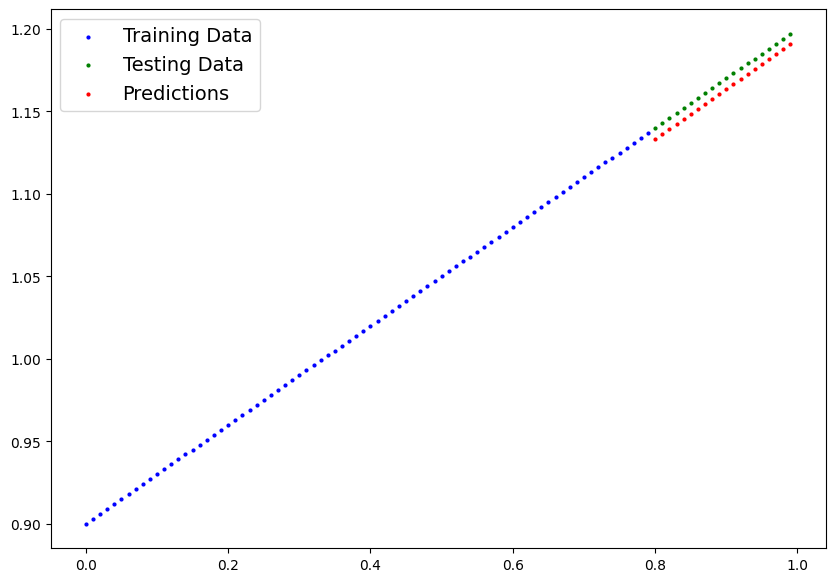

In [42]:
plot_predictions(predictions=y_preds.cpu())


In [43]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: \"{MODEL_SAVE_PATH}\"")
torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)


Saving model to: "models\01_pytorch_workflow_model_2.pth"


In [44]:
# Load a PyTorch Model

# Create a new instance of LinearRegressionModelV2
loaded_model_2 = LinearRegressionModel()

# Load the saved model_1 state_dict
loaded_model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_2.to(device)


LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [45]:
next(loaded_model_2.parameters()).device


device(type='cuda', index=0)

In [46]:
loaded_model_2.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.3028]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8910], device='cuda:0'))])

In [47]:
# Evaluate loaded model
loaded_model_2.eval()
with torch.inference_mode():
    loaded_model_2_preds = loaded_model_2(X_test)
y_preds == loaded_model_2_preds


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')